In [18]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [19]:
training = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Clustering focusing on the 'Kingdom' feature

In [20]:
target_train = training.loc[:,"Kingdom"]
training = training.iloc[:, 6:]

In [21]:
target_train

0        vrl
1        inv
2        bct
3        bct
4        vrt
        ... 
10417    pln
10418    vrl
10419    bct
10420    pln
10421    pln
Name: Kingdom, Length: 10422, dtype: object

In [22]:
X = training
y = target_train

In [23]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

### Function to plot the dendrogram

In [24]:
def plot_dendrogram(Z=None, model=None, X=None, **kwargs):
    annotate_above = kwargs.pop('annotate_above', 0)

    # this block Reconstruct the linakge matrix if the standard model API was used
    if Z is None:
        if hasattr(model, 'distances_') and model.distances_ is not None:
            # create the counts of samples under each node
            counts = np.zeros(model.children_.shape[0])
            n_samples = len(model.labels_)
            for i, merge in enumerate(model.children_):
                current_count = 0
                for child_idx in merge:
                    if child_idx < n_samples:
                        current_count += 1  # leaf node
                    else:
                        current_count += counts[child_idx - n_samples]
                counts[i] = current_count

            Z = np.column_stack([model.children_, model.distances_,
                                              counts]).astype(float)
        else:
            Z = linkage(X, method=model.linkage, metric=model.metric)
            
    #in OUR CASE we are starting here
    #This block checks if the n_clusters keyword argument is provided, if yes it calcualtes the threshold for coloring
    if 'n_clusters' in kwargs:
        n_clusters = kwargs.pop('n_clusters')
        # Set the cut point just above the last but 'n_clusters' merge
        kwargs['color_threshold'] = Z[-n_clusters, 2] + 1e-5 #select the height to cut, Z[-n_clusters, 2] retrieves the distance of the merge that results in exactly n_clusters clusters. This is because Z is sorted by merge order, so Z[-n_clusters] gives the n_clusters-th merge from the end (i.e., the merge that leaves exactly n_clusters clusters).
        #kwargs['color_threshold'] = None
    
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    # Plot the corresponding dendrogram, with keyword arguments
    ddata = dendrogram(Z,ax=ax, **kwargs)
    
    # This block annotates nodes in the dendrogram
    for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']): #x, y coordinates and color
        x = 0.5 * sum(i[1:3]) #position where to plot on x
        y = d[1]  #position where to plot on x
        nid = np.where(Z[:,2] == y)[0][0] #This is the third column of the linkage matrix Z, which contains the distances between clusters at each merge.

        if y > annotate_above:
            plt.plot(x, y, 'o', c=c)
            plt.annotate(str(nid-Z.shape[0]), (x, y), xytext=(0, -5),# The text to be annotated. nid is the index of the merge, and Z.shape[0] is the number of merges. Subtracting these gives the node identifier.
                         textcoords='offset points',
                         va='top', ha='center')
    #This block draws a horizontal line at the color_threshold height to indicate the cut point for clusters.
    if kwargs['color_threshold']:
        plt.axhline(y=kwargs['color_threshold'], c='k')
    
    return fig, ax
   

In [25]:
def plot_dendrogram(Z=None, model=None, X=None, ax=None, **kwargs):
    annotate_above = kwargs.pop('annotate_above', 0)

    # Reconstruct the linkage matrix if the standard model API was used
    if Z is None:
        if hasattr(model, 'distances_') and model.distances_ is not None:
            # create the counts of samples under each node
            counts = np.zeros(model.children_.shape[0])
            n_samples = len(model.labels_)
            for i, merge in enumerate(model.children_):
                current_count = 0
                for child_idx in merge:
                    if child_idx < n_samples:
                        current_count += 1  # leaf node
                    else:
                        current_count += counts[child_idx - n_samples]
                counts[i] = current_count

            Z = np.column_stack([model.children_, model.distances_,
                                 counts]).astype(float)
        else:
            Z = linkage(X, method=model.linkage, metric=model.metric)
            
    # Check if the n_clusters keyword argument is provided
    if 'n_clusters' in kwargs:
        n_clusters = kwargs.pop('n_clusters')
        kwargs['color_threshold'] = Z[-n_clusters, 2] + 1e-5
    
    # Use the provided axis
    if ax is None:
        fig, ax = plt.subplots(figsize=(20, 10))
    else:
        fig = plt.gcf()

    # Plot the dendrogram
    ddata = dendrogram(Z, ax=ax, **kwargs)
    
    # Annotate nodes in the dendrogram
    for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
        x = 0.5 * sum(i[1:3])
        y = d[1]
        nid = np.where(Z[:, 2] == y)[0][0]

        if y > annotate_above:
            ax.plot(x, y, 'o', c=c)
            ax.annotate(str(nid - Z.shape[0]), (x, y), xytext=(0, -5),
                        textcoords='offset points',
                        va='top', ha='center')
    if kwargs.get('color_threshold'):
        ax.axhline(y=kwargs['color_threshold'], c='k')
    
    return fig, ax


## Functions to evaluate the clusters obtained

### Internal indices

In [26]:
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize 

def incidence_mat(y_pred):
    npoints = y_pred.shape[0]
    mat = np.zeros([npoints, npoints])#matrix that contains zeros
    # Retrieve how many different cluster ids there are
    clusters = np.unique(y_pred)
    nclusters = clusters.shape[0]
    
    for i in range(nclusters):
        sample_idx = np.where(y_pred == i)#position of true values, all inside same cluster, contains the indices of all points that belong to the current cluster i.
        # Compute all the possible combinations combinations of these indices
        idx = np.meshgrid(sample_idx, sample_idx)
        mat[idx[0], idx[1]] = 1
        
    return mat

def similarity_mat(X, metric):
    dist_mat = pairwise_distances(X, metric=metric)
    min_dist, max_dist = dist_mat.min(), dist_mat.max()
    
    # Normalize distances in [0, 1] and compute the similarity
    sim_mat = 1 - (dist_mat-min_dist)/(max_dist-min_dist)
    return sim_mat

def correlation(X, y_pred, metric):
    inc = incidence_mat(y_pred)
    sim = similarity_mat(X, metric)
    
    # Note: we can eventually remove duplicate values
    # only the upper/lower triangular matrix
    # triuidx = np.triu_indices(y_pred.shape[0], k=1)
    # inc = inc[triuidx]
    # sim = sim[triuidx]
    
    inc = normalize(inc.reshape(1,-1))#Flattens the incidence matrix into a 1D array (row vector).
    sim = normalize(sim.reshape(1,-1))#Computes the dot product of the normalized incidence and similarity matrices. This gives a single scalar value (since both are now row vectors).
    corr = inc @ sim.T #[1, NF] * [NF, 1] --> [1,1]
    return corr[0,0]   

In [27]:
def wss(X, y_pred, metric):
    # Compute the incidence matrix
    inc = incidence_mat(y_pred)
    # Compute the distances between each pair of nodes
    dist_mat = pairwise_distances(X, metric=metric)
    # Use the incidence matrix to select only the 
    # distances between pair of nodes in the same cluster
    dist_mat = dist_mat*inc
    # Select the lower/upper triangular part of the matrix
    # excluding the diagonal k
    triu_idx = np.triu_indices(X.shape[0], k=1)
    
    #select point that you want, compute the square and sum it
    wss = (dist_mat[triu_idx]**2).sum()
    
    return wss

def bss(X, y_pred, metric):
    # Compute the incidence matrix
    inc = incidence_mat(y_pred)
    # Compute the distances between each pair of nodes
    dist_mat = pairwise_distances(X, metric=metric)
    # Use the incidence matrix to select only the 
    # distances between pair of nodes in different clusters
    dist_mat = dist_mat*(1-inc)
    # Select the lower/upper triangular part of the matrix
    # excluding the diagonal
    triu_idx = np.triu_indices(X.shape[0], k=1)
    
    bss = (dist_mat[triu_idx]**2).sum()
    
    return bss

### External indices

In [28]:
def get_Ncounts(y_predict, y_true, k, j=None):
    #N is the total number of samples
    N = X.shape[0]
    #Nk is the total number of samples in cluster k
    Nk_mask = y_predict==k
    Nk = Nk_mask.sum()
    Nj, Nkj = None, None
    #if we have a label
    if j is not None:
        Nj_mask = y_true==j
        Nj = Nj_mask.sum()
        #samples that are both in cluster k and with label j
        Nkj = np.logical_and(Nk_mask, Nj_mask).sum()
    return N, Nk, Nj, Nkj

##computing precision
def precision(y_predict, y_true, k, j):
    N, Nk, Nj, Nkj = get_Ncounts(y_predict, y_true, k, j)
    return Nkj / (Nk + 1e-8)

#computing recall
def recall(y_predict, y_true, k, j):
    N, Nk, Nj, Nkj = get_Ncounts(y_predict, y_true, k, j)
    return Nkj / (Nj + 1e-8)

#computing F1
def F(y_predict, y_true, k, j):
    p = precision(y_predict, y_true, k, j)
    r = recall(y_predict, y_true, k, j)
    return (2*p*r) / (p+r)

#computing purity
def purity(y_predict, y_true, k):
    cls = np.unique(y_true)
    prec = [precision(y_predict, y_true, k, j) for j in cls]
    return max(prec)

def tot_purity(y_predict, y_true):
    N = y_true.shape[0]
    nc = len(np.unique(y_true))
    p = 0
    for k in range(nc):
        N, Nk, _, _ = get_Ncounts(y_predict, y_true, k)
        pk = purity(y_predict, y_true, k)
        p += (Nk / N) * pk
    return p

### Comparison between different agglomerative methods

Clustering correlation using [single] linkage method is 0.9908999751091847. Random performance is 0.31386205033527603
WSS using [single] linkage method:  945333.0120245282
BSS using [single] linkage method:  7070.100320346078

Clustering correlation using [average] linkage method is 0.9903687626684001. Random performance is 0.3136901311405106
WSS using [average] linkage method:  933437.0206452927
BSS using [average] linkage method:  18966.091699586173

Clustering correlation using [complete] linkage method is 0.6516600830230881. Random performance is 0.3137651593266622
WSS using [complete] linkage method:  185674.2854417494
BSS using [complete] linkage method:  766728.826903125

Clustering correlation using [ward] linkage method is 0.42964279553479634. Random performance is 0.3136588769679456
WSS using [ward] linkage method:  63674.43509506104
BSS using [ward] linkage method:  888728.6772498179



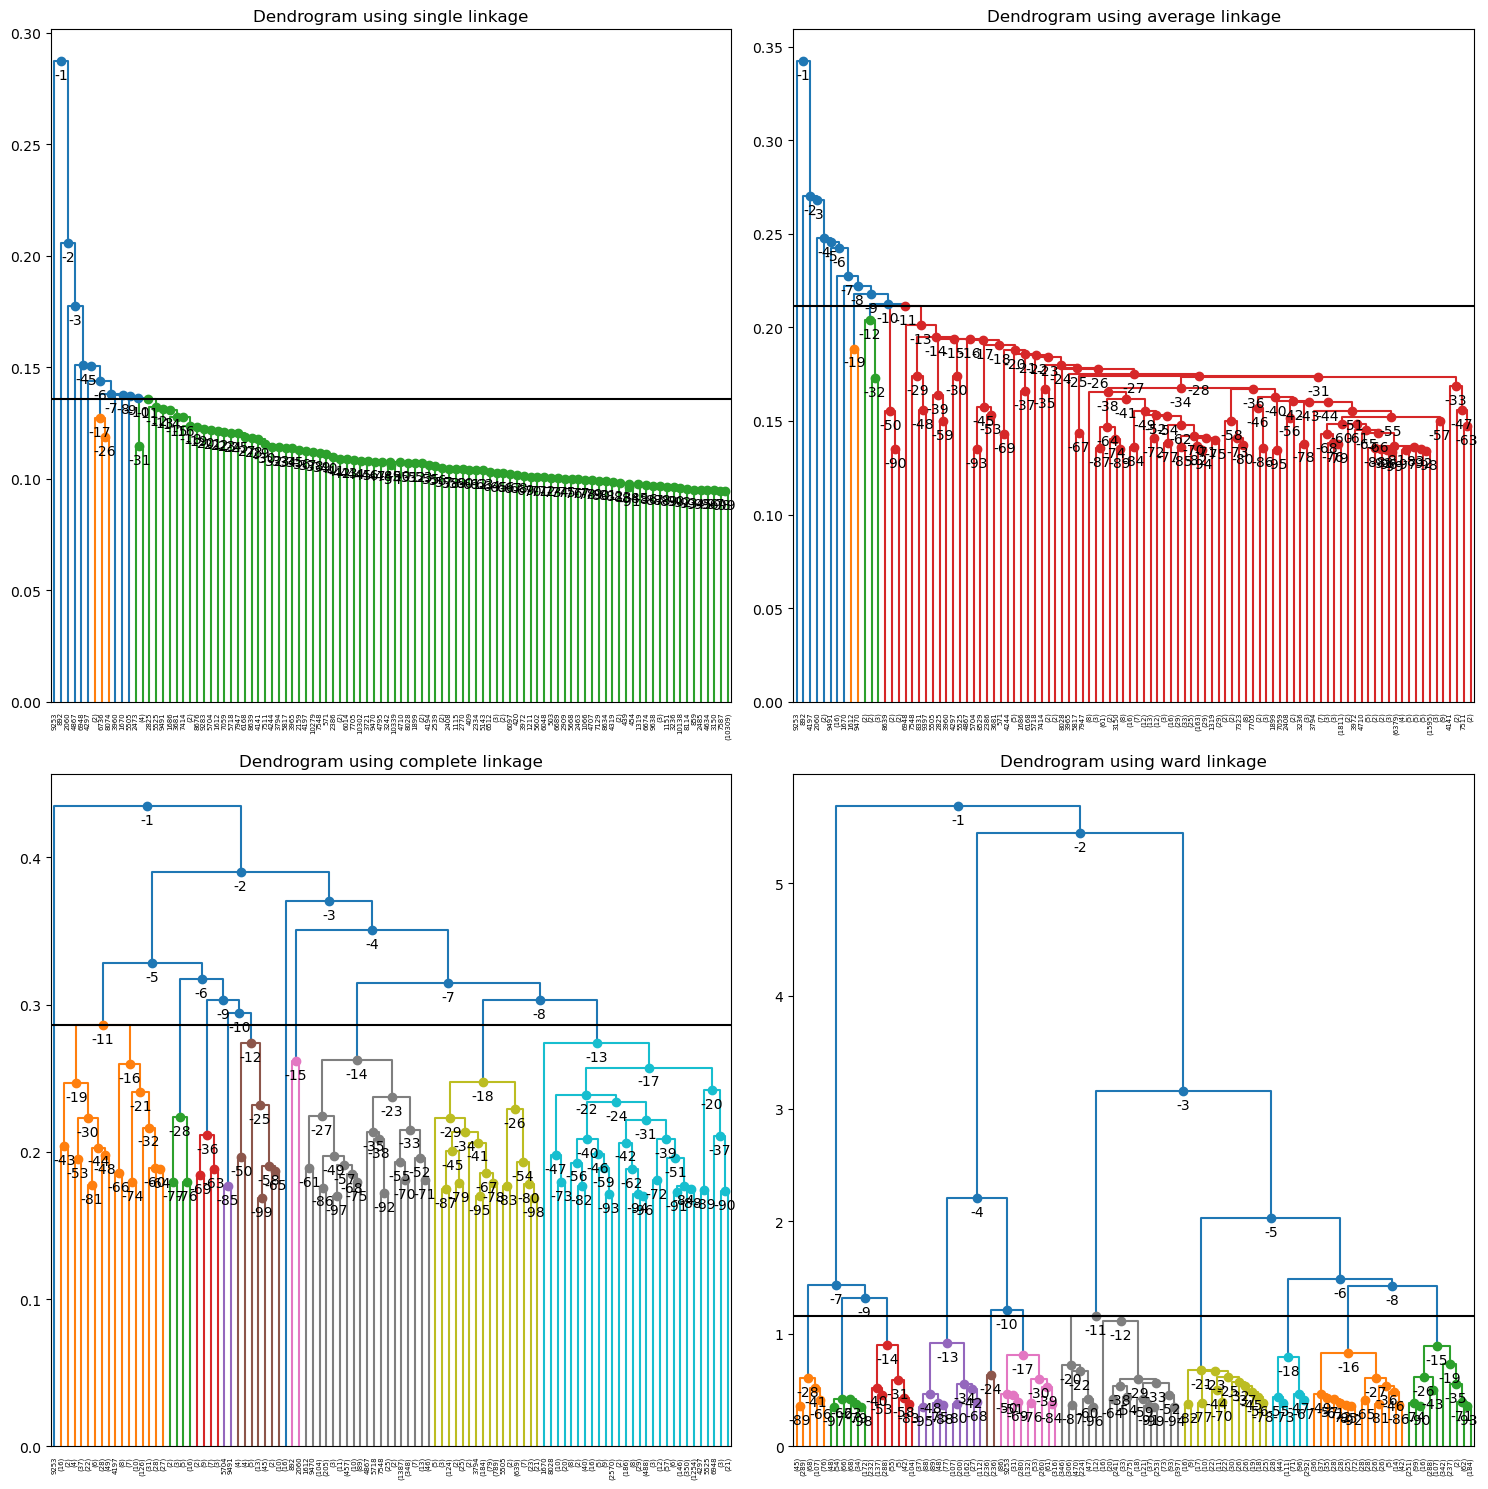

In [32]:
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import numpy as np

methods = ['single', 'average', 'complete', 'ward']
distance_threshold = None

prediction_dict = {'single': None, 'average': None, 'complete': None, 'ward': None}

# Creiamo una figura e una griglia di subplot 2x2
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.flatten()

for i, method in enumerate(methods):
    model = AgglomerativeClustering(n_clusters=11, linkage=method, metric='euclidean')

    y_predict = model.fit_predict(X)
    corr = correlation(X, y_predict, 'euclidean')
    y_rand = np.random.randint(0, 10, X.shape[0])
    rand_corr = correlation(X, y_rand, 'euclidean')
    print("Clustering correlation using [{}] linkage method is {}. Random performance is {}".format(method, corr, rand_corr))
    
    print("WSS using [{}] linkage method: ".format(method), wss(X, y_predict, 'euclidean'))
    print("BSS using [{}] linkage method: ".format(method), bss(X, y_predict, 'euclidean'))
    print("")
    
    tot_purity(y_predict, y)
    
    prediction_dict[method] = y_predict
    
    # Plot dendrogram
    plot_dendrogram(model=model, X=X, truncate_mode='lastp', p=100, 
                    n_clusters=11, ax=axes[i], 
                    color_threshold=distance_threshold)
    axes[i].set_title(f'Dendrogram using {method} linkage')

plt.tight_layout()
plt.show()


### Function to plot the heatmap of the similarity matrix

In [30]:
#This function sorts a similarity matrix based on the cluster labels provided in y_pred.
def sorted_mat(sim, y_pred):
    idx_sorted = np.argsort(y_pred)#sort the array y_pred in ascending order. 
    # Sort the rows
    sim = sim[idx_sorted, :]
    # Sort the columns
    sim = sim[:, idx_sorted]
    return sim

#plotting the heatmap
def plot_sorted_mat(sim, y_pred):
    sim = sorted_mat(sim, y_pred)
    fig, ax = plt.subplots(figsize=(40,30))  
    ax = sns.heatmap(sim, ax=ax)
    # Remove ruler (ticks)
    ax.set_yticks([]) 
    ax.set_xticks([])

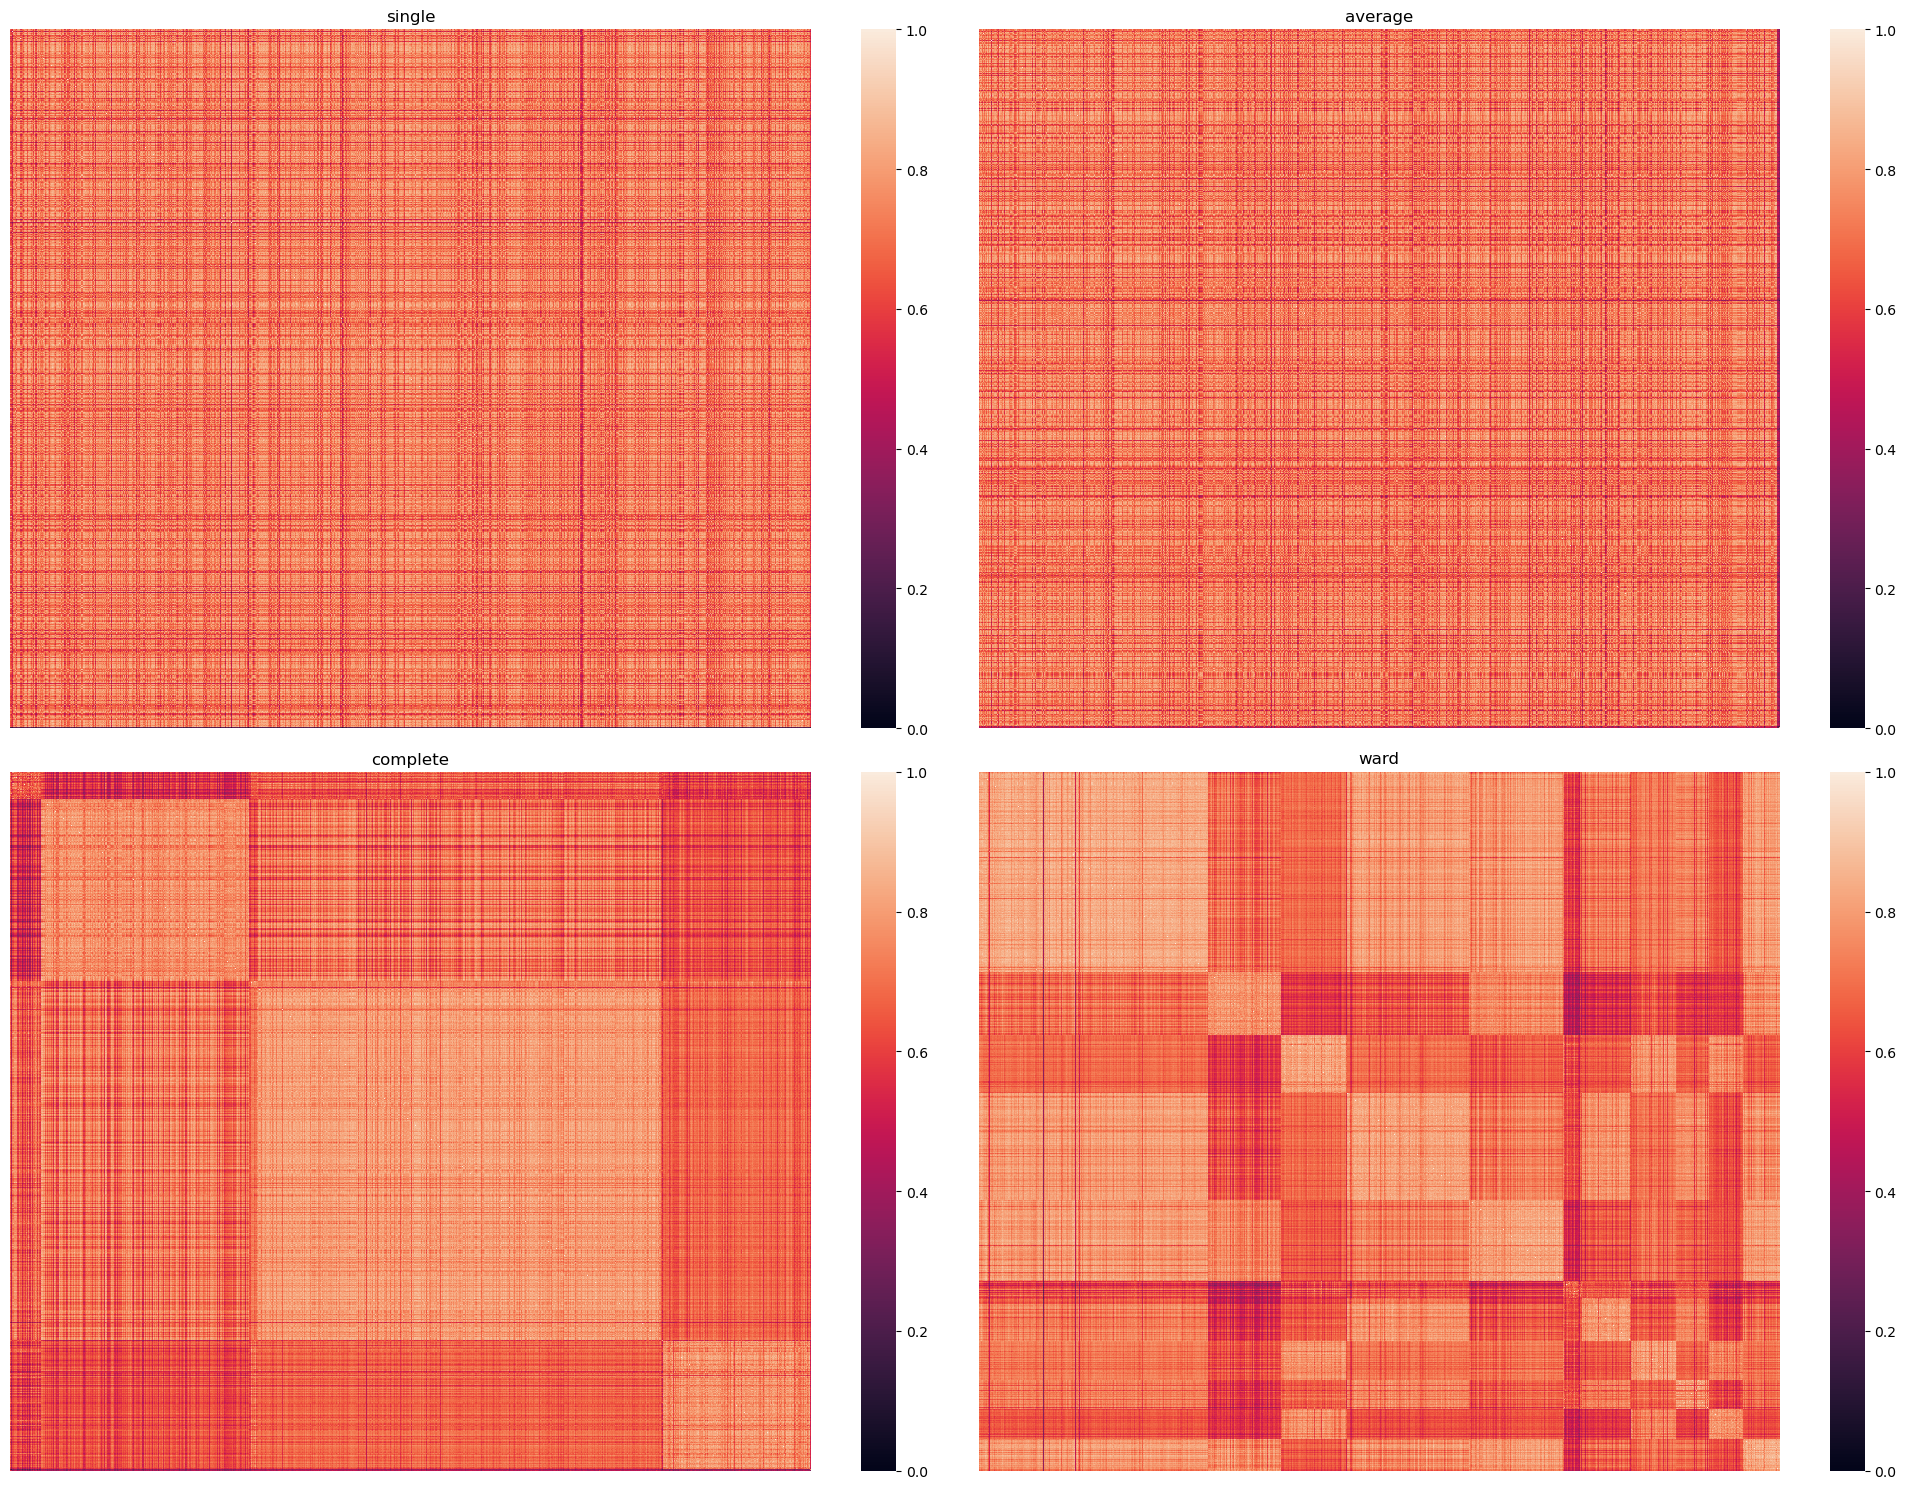

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_sorted_mat(ax, sim, y_pred):
    sim = sorted_mat(sim, y_pred)
    sns.heatmap(sim, ax=ax)
    ax.set_yticks([]) 
    ax.set_xticks([])

fig, axes = plt.subplots(2, 2, figsize=(20, 15)) 

axes = axes.flatten()

for ax, (method, y_predict) in zip(axes, prediction_dict.items()):
    sim = similarity_mat(X, metric='euclidean')
    plot_sorted_mat(ax, sim, y_predict)
    ax.set_title(method)

plt.tight_layout()
plt.show()


## matchare i nomi corretti nella legenda!!

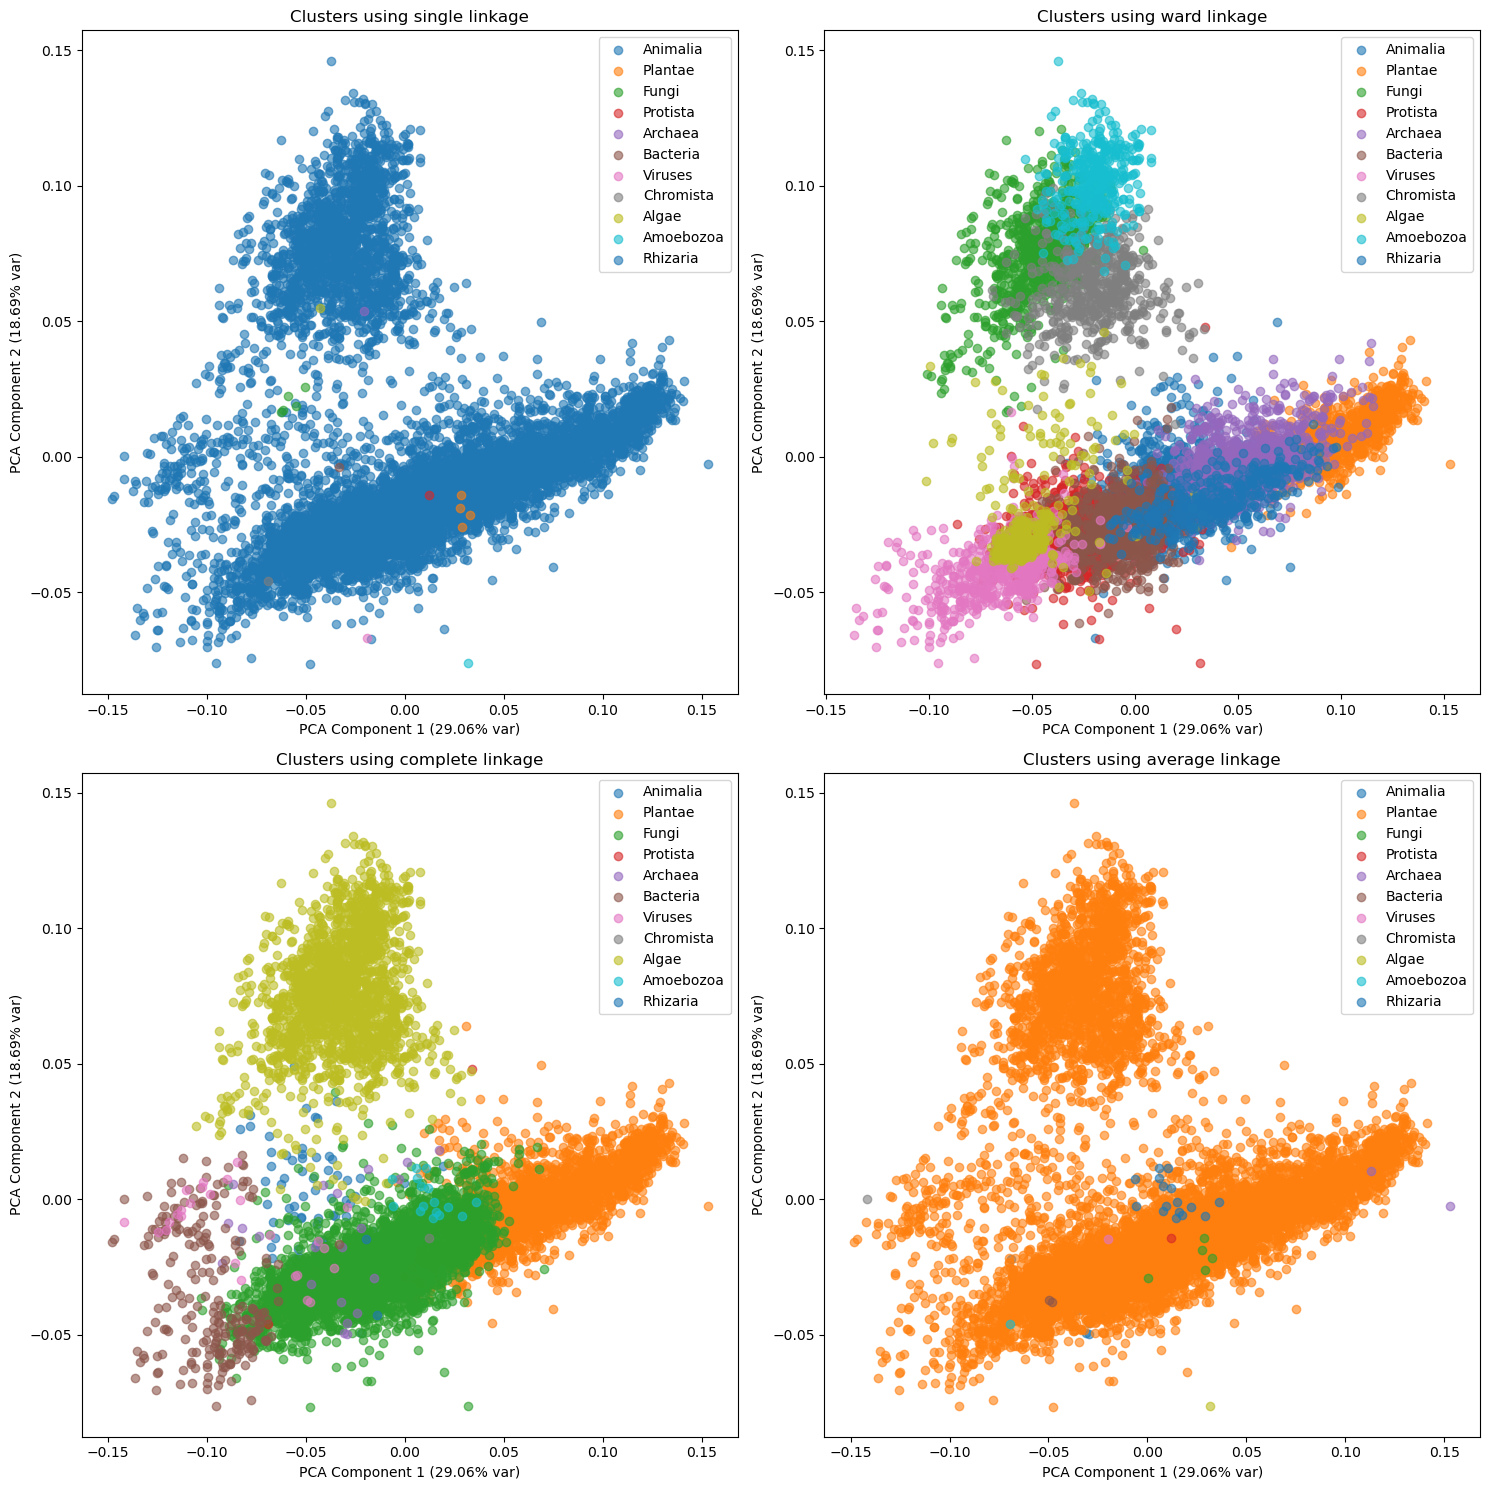

In [38]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

# Define the clustering methods to be used
methods = ['single', 'ward', 'complete', 'average']
clustering_results = {}

# List of kingdom names corresponding to cluster numbers
kingdom_names = [
    'Animalia', 'Plantae', 'Fungi', 'Protista', 'Archaea',
    'Bacteria', 'Viruses', 'Chromista', 'Algae', 'Amoebozoa',
    'Rhizaria'
]

# Fit the clustering models for each method
for method in methods:
    model = AgglomerativeClustering(n_clusters=12, linkage=method)
    y_predict = model.fit_predict(X)
    clustering_results[method] = y_predict

# Reduce dimensionality with PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
explained_variance = pca.explained_variance_ratio_

# Create a 2x2 grid for plotting
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.flatten()

# Plot the clusters for each method
for ax, method in zip(axes, methods):
    y_predict = clustering_results[method]
    ax.set_title(f'Clusters using {method} linkage')
    for i in range(11):
        ax.scatter(X_pca[y_predict == i, 0], X_pca[y_predict == i, 1], label=kingdom_names[i], alpha=0.6)
    ax.set_xlabel(f'PCA Component 1 ({explained_variance[0]*100:.2f}% var)')
    ax.set_ylabel(f'PCA Component 2 ({explained_variance[1]*100:.2f}% var)')
    ax.legend()

plt.tight_layout()
plt.show()

# Clustering on DNAtype